In [97]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [98]:
%matplotlib inline

import pandas as pd
from aeps import AEP_metrics_lims
from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from loading import load_session_data
from target import get_spike_counts
from statsmodels.formula.api import ols, glm
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from spiketrain import inst_rate

np.set_printoptions(suppress=True)

In [99]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [100]:
def pop_activity_score(time_bins, spike_times):
    """
    PCA score (PC1) of activity matrix to compute state
    
    time_bins   - times in seconds from timeline
    spike_times - dict of spike times for each unit
    """
    unit_mx = np.zeros([len(tl), len(spike_times)])
    for j, (unit_id, spk_times) in enumerate(spike_times.items()):
        unit_mx[:, j] = stats.zscore(inst_rate(spk_times, time_bins, k_width=1000))

    pca = decomposition.PCA(n_components=3)
    pca.fit(unit_mx)
    X = pca.transform(unit_mx)
    
    return unit_mx, X[:, 0]

In [103]:
dst_path = "/home/sobolev/nevermind/AG_Pecka/data/processed/"

#sessions = [s for s in selected_009265.keys()]
sessions = [s for s in selected_009266.keys()]
sessions.sort()
#selected = sessions[:2] + sessions[5:]
selected = sessions[:4]
#selected.remove('009266_hippoSIT_2023-04-20_15-24-14')  # only one A1 unit
selected

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51']

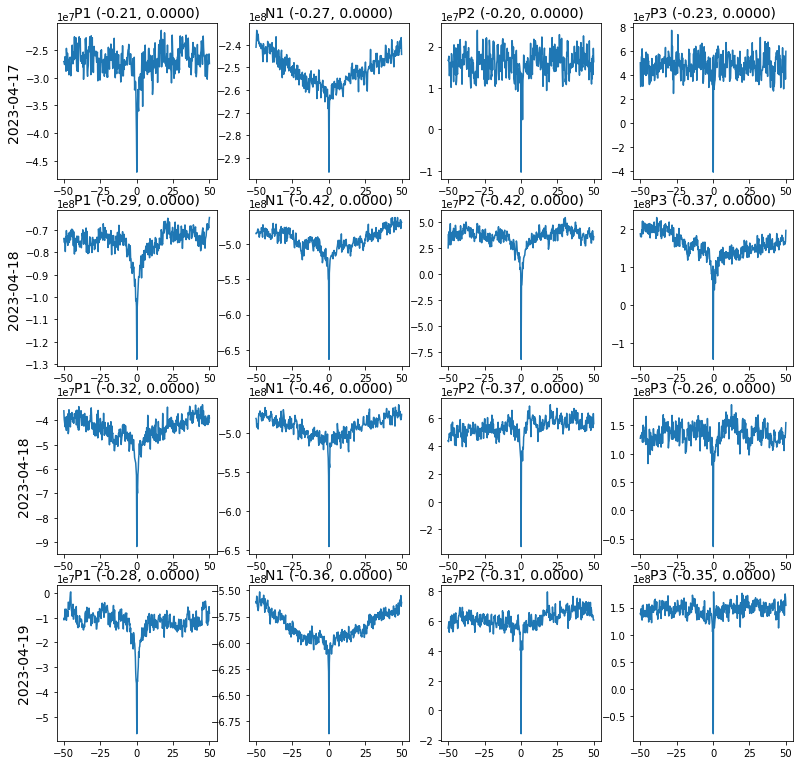

In [106]:
area = 'A1'
metric_names = ['P1', 'N1', 'P2', 'P3']
rows = len(selected)
cols = len(metric_names)
fig, axes = plt.subplots(rows, cols, figsize=(3.3*cols, 3.3*rows))

for k, session in enumerate(selected):
    # read AEPs- and meta- data
    animal      = session.split('_')[0]
    meta_file   = os.path.join(dst_path, animal, session, 'meta.h5')
    units_file  = os.path.join(dst_path, animal, session, 'units.h5')
    aeps_c_file = os.path.join(dst_path, animal, session, 'analysis', 'AEP_components.h5')

    with h5py.File(meta_file, 'r') as f:
        sound_events = np.array(f['processed']['sound_events'])
        tgt_mx       = np.array(f['processed']['target_matrix'])
        tl           = np.array(f['processed']['timeline'])

    aep_metrics = {}
    with h5py.File(aeps_c_file, 'r') as f:
        for area in f:
            aep_metrics[area] = {}
            for x in f[area]:
                aep_metrics[area][x] = np.array(f[area][x])
        
    single_units, spike_times = {}, {}
    with h5py.File(units_file, 'r') as f:
        unit_names = [x for x in f]
    with h5py.File(units_file, 'r') as f:
        for unit_name in unit_names:
            spike_times[unit_name]  = np.array(f[unit_name][H5NAMES.spike_times['name']])
            single_units[unit_name] = np.array(f[unit_name][H5NAMES.inst_rate['name']])
            
    # compute population activity
    spike_times_A1 = dict([(name, spk_times) for name, spk_times in spike_times.items() if int(name[0]) < 3])
    unit_mx, pop_act = pop_activity_score(tl[:, 0], spike_times_A1)

    if stats.pearsonr(pop_act, unit_mx.mean(axis=1))[0] < 0:
        pop_act = (-1)*pop_act
        
    # filter very low oscillations 
    # maybe it's a result? check if it's because of badly sorted spike clusters
    s_rate, low_cut, high_cut = 100, 0.01, 10  # Hz
    sos = signal.butter(10, [low_cut / (0.5*s_rate), high_cut/(0.5*s_rate)], analog=False, btype='band', output='sos')
    pop_act_filt = signal.sosfiltfilt(sos, pop_act)
    
    # all indices to sound event sampling
    sound_event = 1
    speed_min = 0.04 # 0.04 - idle
    pop_mean  = pop_act_filt.mean()
    
    idxs_sel_events  = np.where(sound_events[:, 1] == sound_event)[0]  # idxs to SE
    idxs_idle_events = np.where(tl[sound_events[:, 2].astype(np.int32)][:, 3] < speed_min)[0]  # idxs to SE
    idxs_AEPs = np.intersect1d(idxs_sel_events, idxs_idle_events)
    
    idxs_sel_tl  = sound_events[sound_events[:, 1] == sound_event][:, 2].astype(np.int32)  # idxs to TL
    idxs_idle_tl = np.where(tl[:, 3] < speed_min)[0]  # idxs to TL
    idxs_pop_act = np.intersect1d(idxs_sel_tl, idxs_idle_tl)
    
    #idxs_tgt  = np.where(sound_events[:, 1] == 2)[0]  # filter successful only?
    #idxs_high = np.where(pop_act_filt[sound_events[:, 2].astype(np.int32)] > pop_mean)[0]
    #idxs_low  = np.where(pop_act_filt[sound_events[:, 2].astype(np.int32)] < pop_mean)[0]
    #idxs_high = np.intersect1d(idxs_bgr, idxs_high)
    #idxs_low  = np.intersect1d(idxs_bgr, idxs_low)

    for i, metric in enumerate(metric_names):
        bins, unit_mx = unit_response_matrix(session, 'A1')
        resp_at_phase = unit_mx[i+1::6]
        unit_act_matrix = resp_at_phase.T
        for u, unit_data in enumerate(unit_act_matrix):
            unit_act_matrix[u] = stats.zscore(unit_data)
        resp_at_phase = unit_act_matrix.T
        pop_response  = resp_at_phase.sum(axis=1)  # one way
        
        # smooth?
        #k_width = 40
        #kernel  = signal.gaussian(k_width, std=(k_width) / 7.2)
        #pop_response = np.convolve(pop_response, kernel, 'same') / kernel.sum()

        s_rate = 4  # Hz, timeline sampling
        t_lag = 50    # in seconds
        metric1 = aep_metrics['A1']["%s_raw" % metric][idxs_AEPs]
        #metric2 = pop_act_filt[idxs_pop_act]
        metric2 = pop_response[idxs_AEPs]
        corr = signal.correlate(metric1, metric2, mode='same')

        p_corr, p_val = stats.pearsonr(metric1, metric2)
                       
        idx_l, idx_r = int(len(corr)/2) - t_lag*s_rate, int(len(corr)/2) + t_lag*s_rate
        x_vals = np.linspace(-t_lag, t_lag, idx_r - idx_l)

        ax = axes[k, i]
        ax.plot(x_vals, corr[idx_l:idx_r])
        ax.set_title("%s (%.2f, %.4f)" % (metric, p_corr, p_val), fontsize=14)
        if i == 0:
            ax.set_ylabel(session[-19:-9], fontsize=14)
        #ax.axvline(0, color='black', ls='--')
        #ax.axvline(x_vals[corr[idx_l:idx_r].argmin()], color='red')
